## 2+.1 多层感知机(MLP)与训练
> 2+章节主要作为2章节的补充，介绍在Pytorch中如何使用深度学习的相关技术。

### 模型启发
感知机模型:
* 感知机是一个二分类模型，是最早的Al模型之一
* 它的求解算法等价于使用批量大小为1的梯度下降
* 它不能拟合XOR函数，导致的第一次AI寒冬。（只能产生线性分割面）

为此，人们后来引入多层感知机来解决**XOR**的问题。
![image-20211015202057316](https://s2.loli.net/2022/03/25/zaGI8cY9Jt6BAwd.png)

下面是**单隐藏层**的MLP示意图:
![image-20211015202124078](https://s2.loli.net/2022/03/25/Zf7JbiW92t6C3Bn.png)


### 激活函数
引入非线性的激活函数，其公式如下（$\sigma$为按元素的激活函数）：

$$
输入 $\mathbf{x} \in \mathbb{R}^{n}$ \\
隐藏层 $\mathbf{W}_{1} \in \mathbb{R}^{m \times n}, \mathbf{b}_{1} \in \mathbb{R}^{m}$  \\
输出层 $\mathbf{w}_{2} \in \mathbb{R}^{m}, b_{2} \in \mathbb{R}$
$$
\begin{aligned}
&\mathbf{h}=\sigma\left(\mathbf{W}_{1} \mathbf{x}+\mathbf{b}_{1}\right) \\
&o=\mathbf{w}_{2}^{T} \mathbf{h}+b_{2}
\end{aligned}
$$
$$

下面我们通过`python`代码将几种常见的激活函数画出来:

In [11]:
%matplotlib inline
import torch
from d2l import torch as d2l

* ReLU

简单好用:
$$\textbf{ReLU}(x) = max(x, 0)$$

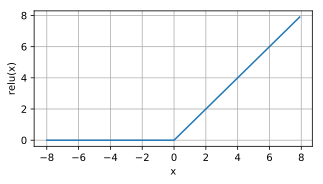

In [12]:
x = torch.arange(-8.0, 8.0, 0.1, requires_grad=True)
y = torch.relu(x)
d2l.plot(x.detach(), y.detach(), 'x', 'relu(x)', figsize=(5, 2.5))  # detach() 去掉梯度

下面绘制ReLU的导数:

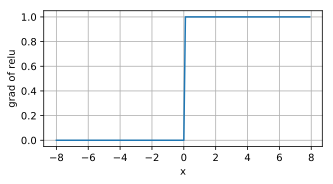

In [13]:
y.backward(torch.ones_like(x), retain_graph=True)
d2l.plot(x.detach(), x.grad, 'x', 'grad of relu', figsize=(5, 2.5))

可以看到，使用ReLU的原因是，它求导表现得特别好：要么让参数消失，要么让参数通过。 这使得优化表现得更好，并且ReLU减轻了困扰以往神经网络的梯度消失问题

* sigmoid

(0, 1)之间:
$$\operatorname{sigmoid}(x)=\frac{1}{1+\exp (-x)}$$

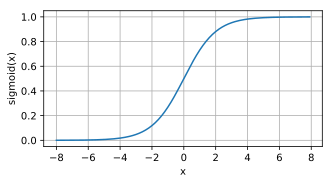

In [14]:
y = torch.sigmoid(x)
d2l.plot(x.detach(), y.detach(), 'x', 'sigmoid(x)', figsize=(5, 2.5))

其导数为:

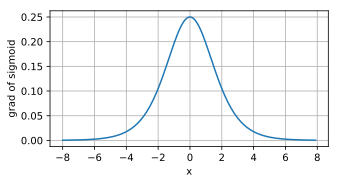

In [15]:
# 清除以前的梯度
x.grad.data.zero_()
y.backward(torch.ones_like(x),retain_graph=True)
d2l.plot(x.detach(), x.grad, 'x', 'grad of sigmoid', figsize=(5, 2.5))

当输入为0时，sigmoid函数的导数达到最大值0.25； 而输入在任一方向上越远离0点时，导数越接近0。

* tanh

当输入在0附近时，tanh函数接近线性变换。 函数的形状类似于sigmoid函数， 不同的是tanh函数关于坐标系原点中心对称：
$$\tanh (x)=\frac{1-\exp (-2 x)}{1+\exp (-2 x)}$$

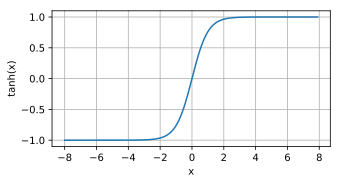

In [16]:
y = torch.tanh(x)
d2l.plot(x.detach(), y.detach(), 'x', 'tanh(x)', figsize=(5, 2.5))

其导数为：

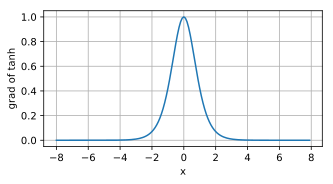

In [17]:
# 清除以前的梯度
x.grad.data.zero_()
y.backward(torch.ones_like(x),retain_graph=True)
d2l.plot(x.detach(), x.grad, 'x', 'grad of tanh', figsize=(5, 2.5))

 当输入接近0时，tanh函数的导数接近最大值1。 与我们在sigmoid函数图像中看到的类似， 输入在任一方向上越远离0点，导数越接近0。

### 多层感知机代码实现
通过上面的介绍，相信对多层感知机有了一定的了解。下面我们运用之前学到过的知识来调佣`Pytorch`的`API`实现多层感知机。

In [18]:
import torch
from torch import nn
from d2l import torch as d2l

* 定义模型

In [19]:
net = nn.Sequential(
    nn.Flatten(),
    nn.Linear(784, 256),
    nn.ReLU(),
    nn.Linear(256, 10)
)

def init_weights(m):
    """
    初始化模型参数
    :param m:
    :return:
    """
    if type(m) == nn.Linear:
        nn.init.normal_(m.weight, std=0.01)

net.apply(init_weights)

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=256, bias=True)
  (2): ReLU()
  (3): Linear(in_features=256, out_features=10, bias=True)
)

* 开始训练：
由于计算资源优先，这里不做训练，感兴趣的读者可以将`d2l.train_ch3(net, train_iter, test_iter, loss, num_epochs, trainer)`取消注释查看训练效果。

In [20]:
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)
# 训练
batch_size, lr, num_epochs = 256, 0.1, 10
loss = nn.CrossEntropyLoss()
trainer = torch.optim.SGD(net.parameters(), lr=lr)

# d2l.train_ch3(net, train_iter, test_iter, loss, num_epochs, trainer)

### $Xavier$初始

在上面的部分，我们使用正态分布来初始化权重值。如果我们不指定初始化方法， 框架将使用默认的随机初始化方法，对于中等难度的问题，这种方法通常很有效。

* 在合理值区间里随机初始参数
* 训练开始的时候更容易有数值不稳定
  * 远离最优解的地方损失函数表面可能很复杂
  * 最优解附近表面会比较平
* 使用$N$(0, 0.01)来初始可能对小网络没问题，但不能保证深度神经网络


* **期望**

  > **均值均为0**

![image-20220325114621260](https://s2.loli.net/2022/03/25/xvRjoNsUhm7QIyq.png)

* **方差**

> 输入和输出的方差一样
>
> 所以$n_{t-1} \gamma_{t}=1$
>
> * 因为 $h^t$ 是由 $t-1$ 层的 $n$ 个参数 $w$ 运算求得的，而 t-1 层的这些参数之前假设了他们都是服从方差为 $\gamma$ 的分布，所以他们相加就成了 $n_{t-1}\gamma$, 了。
>
> ![image-20211102191920125](C:\Users\Gary\AppData\Roaming\Typora\typora-user-images\image-20211102191920125.png)

$$
\begin{aligned}
\operatorname{Var}\left[h_{i}^{t}\right] &=\mathbb{E}\left[\left(h_{i}^{t}\right)^{2}\right]-\mathbb{E}\left[h_{i}^{t}\right]^{2}=\mathbb{E}\left[\left(\sum_{j} w_{i, j}^{t} h_{j}^{t-1}\right)^{2}\right] \\
&=\mathbb{E}\left[\sum_{j}\left(w_{i, j}^{l}\right)^{2}\left(h_{j}^{t-1}\right)^{2}+\sum_{j \neq k} w_{i, j}^{l} w_{i, k}^{t} h_{j}^{t-1} h_{k}^{t-1}\right] \\
&=\sum_{j} \mathbb{E}\left[\left(w_{i, j}^{l}\right)^{2}\right] \mathbb{E}\left[\left(h_{j}^{t-1}\right)^{2}\right] \\
&=\sum_{j} \operatorname{Var}\left[w_{i, j}^{t}\right] \operatorname{Var}\left[h_{j}^{t-1}\right]=n_{t-1} \gamma_{t} \operatorname{Var}\left[h_{j}^{t-1}\right]
\end{aligned}
$$

$n_{t-1} \gamma_{t}=1$



* **反向均值和方差**

> * 均值为0
> * 方差一样

$$
\begin{aligned}
&\frac{\partial \ell}{\partial \mathbf{h}^{t-1}}=\frac{\partial \ell}{\partial \mathbf{h}^{t}} \mathbf{W}^{t} =>\quad\left(\frac{\partial \ell}{\partial \mathbf{h}^{t-1}}\right)^{T}=\left(W^{t}\right)^{T}\left(\frac{\partial \ell}{\partial \mathbf{h}^{t}}\right)^{T} \\
&\mathbb{E}\left[\frac{\partial \ell}{\partial h_{i}^{t-1}}\right]=0 \\
&\operatorname{Var}\left[\frac{\partial \ell}{\partial h_{i}^{t-1}}\right]=n_{t} \gamma_{t} \operatorname{Var}\left[\frac{\partial \ell}{\partial h_{j}^{t}}\right] \quad=>n_{t} \gamma_{t}=1
\end{aligned}
$$



* $Xavier$初始化

> 输入输出很难控制的

![image-20220325114548076](https://s2.loli.net/2022/03/25/nvOiNbFwpjIMXl2.png)

$Xavier$初始化代码如下:

In [21]:
import math

def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.normal_(m.weight, std=math.sqrt(2/(m.in_features+m.out_features)))
net.apply(init_weights)

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=256, bias=True)
  (2): ReLU()
  (3): Linear(in_features=256, out_features=10, bias=True)
)